<font color="green">**K-Nearest Neighbor model for stock prediction using stock data**</font>

**Import Libraries**

In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

#Data Scaling Library
from sklearn.preprocessing import MinMaxScaler

#Error Metrics Library
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#KNN Libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#Data Visualization Library
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [2]:
#Get the stock quote for Disney
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#Use the below code to get stock quotes for other companies: Apple, AMD, Tesla
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-10-30')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


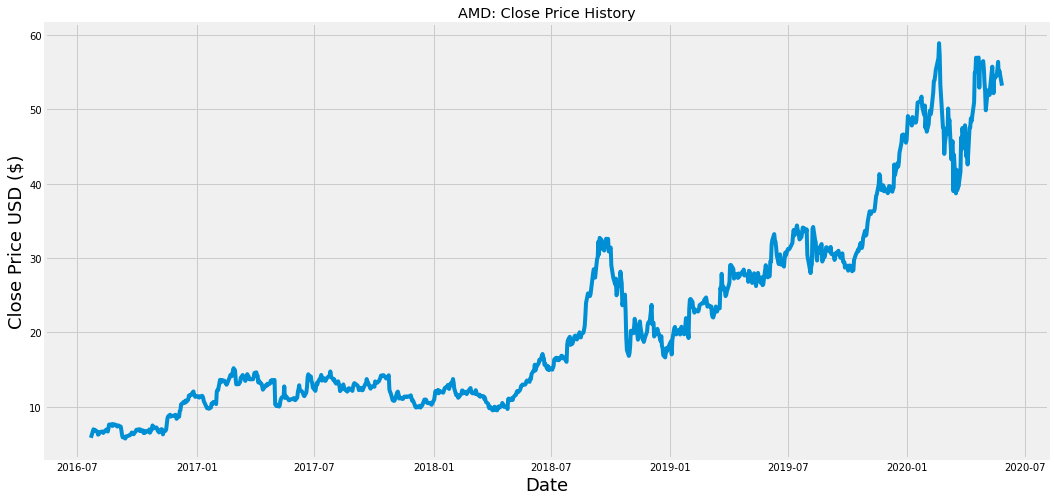

In [3]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('AMD: Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [4]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

print("Training Data Length: ", training_data_len)

Training Data Length:  774


In [5]:
#Scale the all of the data to be values between 0 to 1 range
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [6]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [7]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [9]:
x_train.shape

(714, 60)

In [10]:
x_test.shape

(193, 60)

**KNN: Build model and train using the training data**

In [11]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[1,2,3,4,5]}
knn = neighbors.KNeighborsRegressor(n_neighbors=5)  ## Neighbors with size 1,5,20 is tested with 5 as the optimal performer
model = GridSearchCV(knn, params, cv=10)

x_train = x_train.reshape(714,60)

#fit the model on training data
model.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Predict on testing data and visualize predictions**

In [12]:
x_test = x_test.reshape(193,60)

In [13]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  15.00470216849413


In [14]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


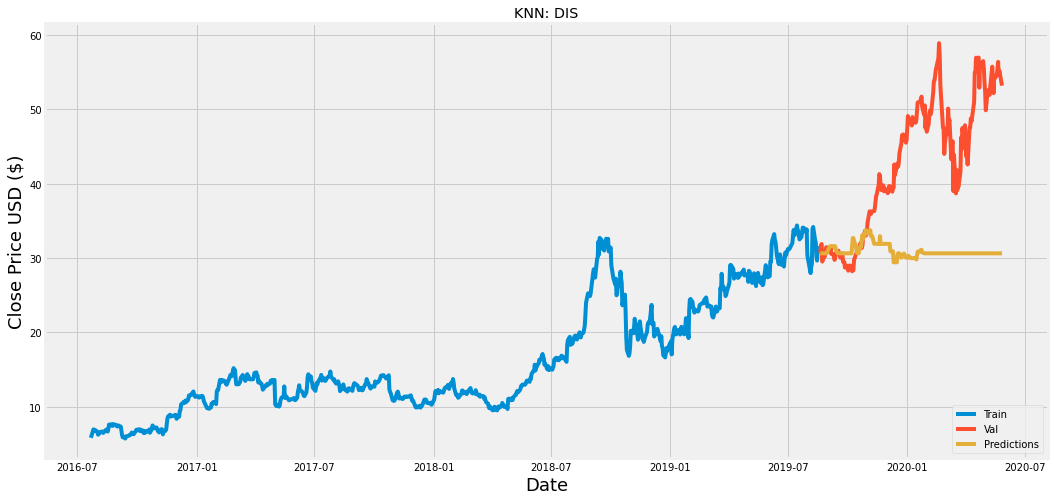

In [15]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN: DIS')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**K-Nearest Neighbor model for stock prediction using stock data and semantic scores**</font>

**Get semantic scores data and preprocess**

In [16]:
#Read semantic scores data from file
newsScores=pd.read_csv('amd-scores.csv')
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,NaN
2,2016-07-24,NaN


In [17]:
#Impute missing values
newsScores=newsScores.ffill(axis=0)
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,0.291504
2,2016-07-24,0.291504


In [18]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98


In [19]:
newsScores.dtypes

date                     object
final_semantic_score    float64
dtype: object

In [20]:
newsScores['date'] = pd.to_datetime(newsScores['date'])

**Merge stock data with semantic scores data and visualize**

In [21]:
#Merge two datasets
merged_data = pd.merge(left=df1, right=newsScores, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,final_semantic_score
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,0.291504
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,0.291504
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,0.291504


In [22]:
merged_data.set_index('Date')
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,final_semantic_score
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,0.291504
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,0.291504
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,0.291504


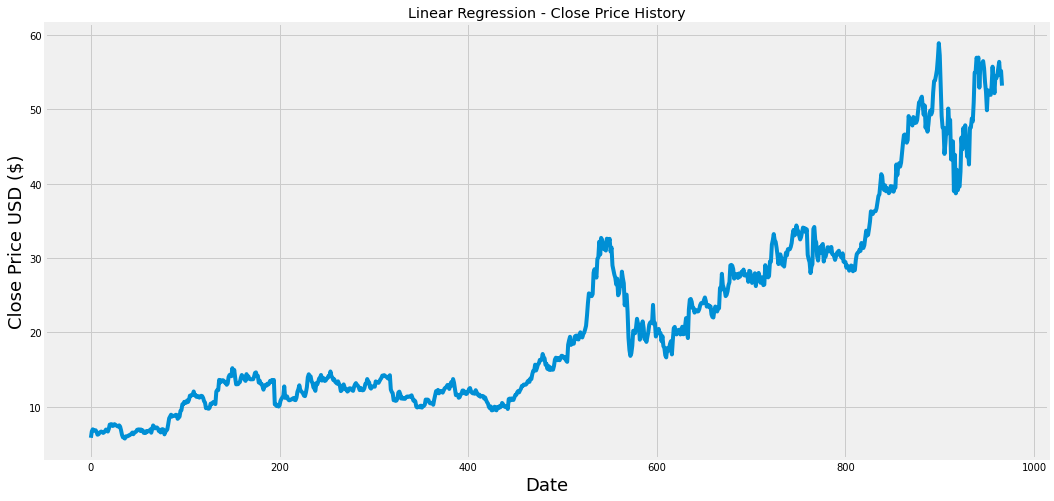

In [23]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Linear Regression - Close Price History')
plt.plot(merged_data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess merged data and split into train-test datasets**

In [24]:
#Create a new dataframe with only the 'Close' column
data = merged_data.filter(['Close', 'Open','final_semantic_score'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [25]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [26]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,:])
  y_train.append(dataset[i,0])

In [27]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  df['Close'][training_data_len :]
# y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,:])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [29]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**KNN: Build model and train using the training datat**

In [30]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[1,2,3,4,5]}
knn = neighbors.KNeighborsRegressor(n_neighbors=5)  ## Neighbors with size 1,5,20 is tested with 5 as the optimal performer
model = GridSearchCV(knn, params, cv=10)

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

#fit the model on training data
model.fit(x_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

**Predict on testing data and visualize predictions**

In [31]:
nsamples_test, nx_test, ny_test = x_test.shape
x_test = x_test.reshape((nsamples_test,nx_test*ny_test))

In [32]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
# preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  14.568507238951515


In [33]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


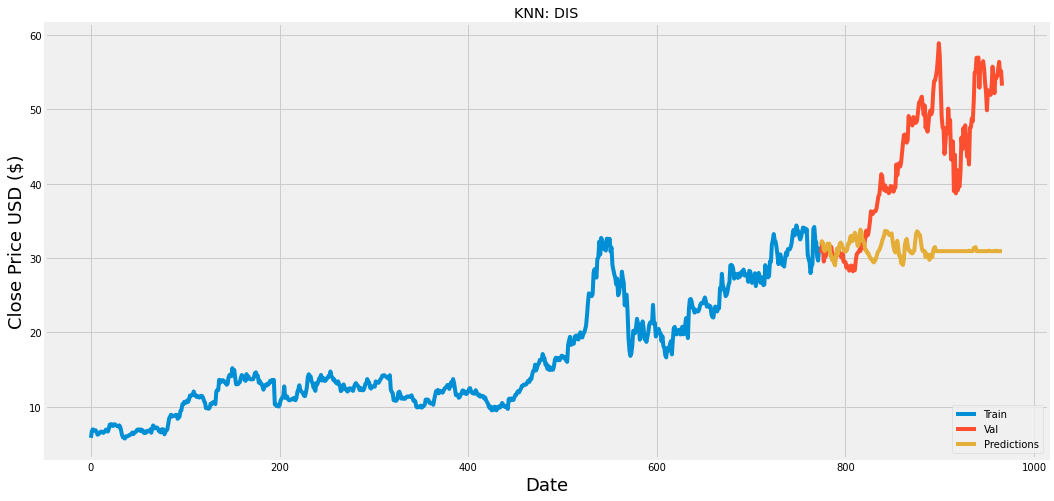

In [34]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN: DIS')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()